In [1]:
%load_ext autoreload
%autoreload 2

import pyhf
import numpy as np
import matplotlib.pyplot as plt 
from pyhfcorr import decorrelate

In [2]:
bins = np.arange(11)
bin_cents = (bins[1:]+bins[:-1])/2

hist1 = np.array([1.5, 3., 6., 7.5, 6.3, 6.6, 5.5, 2.5, 3. , 1.5])
hist1_err = np.array([0.4 , 0.4 , 0.3 , 0.2 , 0.15, 0.4 , 0.45, 0.5 , 0.3 , 0.35])
hist2 = np.array([3. , 6., 9., 12., 15., 9. , 6., 3. , 3.3, 2.15])
hist2_err = np.array([1. , 1. , 3. , 2. , 2., 1. , 2., 2. , 1. , 1.])


data = np.array([ 4, 17, 26, 23, 34, 23, 21,  7,  8,  4])

In [3]:
samples = [
    {
        "name": "sample1",
        "data": list(hist2/2),
        "modifiers": [
            {"name": "mu1", "type": "normfactor", "data" : None},
            {
                "name": "hun1",
                "type": "histosys",
                "data": {
                    "lo_data": list(hist2/2 - hist1/2),
                    "hi_data": list(hist2/2 + hist1/2)
                }
            }
        ],
    },
    {
        "name": "sample2",
        "data": list(hist2/2),
        "modifiers": [
            {"name": "mu2", "type": "normfactor", "data" : None},
            {
                "name": "hun1",
                "type": "histosys",
                "data": {
                    "lo_data": list(hist2/2 - hist1/2),
                    "hi_data": list(hist2/2 + hist1/2)
                }
            }
        ],
    },
]
spec = {"channels" : [{"name" : "singlechannel", "samples" : samples}]}

# info: the `poi_name=None` is nescessary here since we don't want to do a hypothesis test
model = pyhf.Model(spec, poi_name=None)

[1, 1.0, 1.0]


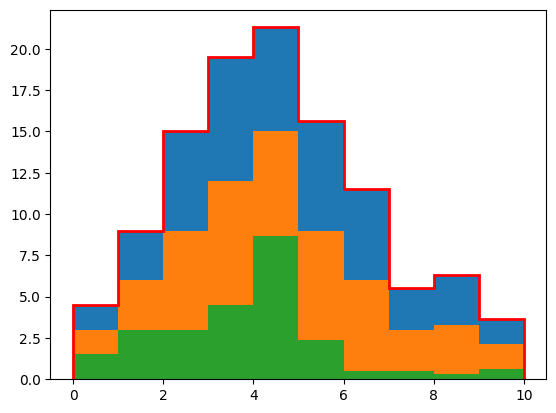

In [4]:
plt.stairs(hist1+hist2, bins, baseline=hist2, fill = True)
plt.stairs(hist2, bins, fill=True)
plt.stairs(hist2-hist1, bins, fill=True)


initial_parameters = model.config.suggested_init()
initial_parameters[0] = 1
# initial_parameters[1] = 1

plt.stairs(model.expected_data(initial_parameters, include_auxdata=False), bins, linewidth=2, color='r')
# plt.errorbar(bin_cents, model.config.auxdata, yerr=np.sqrt(model.config.auxdata), fmt='o')
print(initial_parameters)


# Correlations within sample

In [5]:
# add correlated parameters to pyhf model
samples = [
    {
        "name": "sample1",
        "data": list(hist2),
        "modifiers": [
            {"name": "mu", "type": "normfactor", "data" : None},
            {
                "name": "u1",
                "type": "histosys",
                "data": {
                    "lo_data": list(hist2-hist1),
                    "hi_data": list(hist2+hist1)
                }
            },
            {
                "name": "u2",
                "type": "histosys",
                "data": {
                    "lo_data": list(hist2-hist2),
                    "hi_data": list(hist2+hist2)
                }
            }
        ],
        
    },
]
spec = {"channels" : [{"name" : "singlechannel", "samples" : samples}]}
model = pyhf.Model(spec)


In [6]:
spec = {
    "channels" : [{"name" : "singlechannel", "samples" : samples}], 
    "correlations": [
        {
            "name": "corr",
            "vars": ["u1", "u2"],
            "corr": [[1., 1.], [1., 1.]],
        }
    ]}
new_spec = decorrelate.decorrelate(spec)
new_model = pyhf.Model(new_spec)
new_spec

correlation found


/filer/z-sv-pool12c/l/Lorenz.Gaertner/pyhf-corr/src/pyhfcorr/decorrelate.py:102: UserWarning: Modifier corr[1] is redundant and is not added.
  warnings.warn(f"Modifier {name} is redundant and is not added.")


{'channels': [{'name': 'singlechannel',
   'samples': [{'name': 'sample1',
     'data': [3.0, 6.0, 9.0, 12.0, 15.0, 9.0, 6.0, 3.0, 3.3, 2.15],
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None},
      {'type': 'histosys',
       'data': {'lo_data': [-1.5,
         -3.0,
         -6.0,
         -7.5,
         -6.300000000000001,
         -6.6,
         -5.5,
         -2.5,
         -3.0,
         -1.5],
        'hi_data': [7.5, 15.0, 24.0, 31.5, 36.3, 24.6, 17.5, 8.5, 9.6, 5.8]},
       'name': 'corr[0]'}]}]}]}

In [7]:
new_model.config.par_map

{'corr[0]': {'slice': slice(0, 1, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x149499535d80>},
 'mu': {'slice': slice(1, 2, None),
  'paramset': <pyhf.parameters.paramsets.unconstrained at 0x1494995376a0>}}

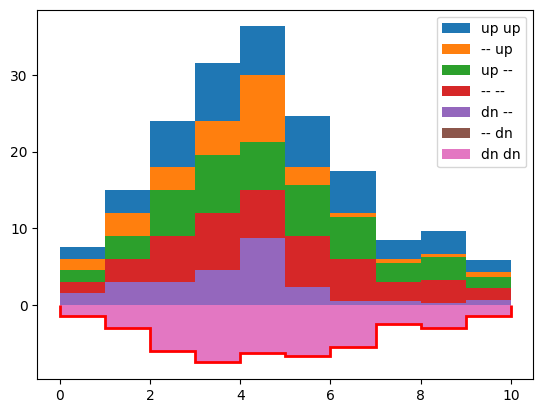

In [8]:
plt.stairs(hist2+hist1+hist2, bins, fill = True, label = 'up up')
plt.stairs(hist2+hist2, bins, fill = True, label = '-- up')
plt.stairs(hist2+hist1, bins, fill = True, label = 'up --')
plt.stairs(hist2, bins, fill=True, label = '-- --')
plt.stairs(hist2-hist1, bins, fill=True, label = 'dn --')
plt.stairs(hist2-hist2, bins, fill=True, label = '-- dn')
plt.stairs(hist2-hist1-hist2, bins, fill=True, label = 'dn dn')

initial_parameters = new_model.config.suggested_init()
initial_parameters[0] = -1.

plt.stairs(new_model.expected_data(initial_parameters, include_auxdata=False), bins, linewidth=2, color='r')

plt.legend()

# Correlations across samples

In [9]:
# add correlated parameters to pyhf model
samples = [
    {
        "name": "sample1",
        "data": list(hist1),
        "modifiers": [
            {"name": "mu", "type": "normfactor", "data" : None},
            {
                "name": "u1",
                "type": "histosys",
                "data": {
                    "lo_data": list(hist1-hist1),
                    "hi_data": list(hist1+hist1)
                }
            },
            {
                "name": "u12",
                "type": "histosys",
                "data": {
                    "lo_data": list(hist1-hist2),
                    "hi_data": list(hist1+hist2)
                }
            }
        ],
        
    },    
    {
        "name": "sample2",
        "data": list(hist2),
        "modifiers": [
            {
                "name": "u1",
                "type": "histosys",
                "data": {
                    "lo_data": list(hist2-hist1),
                    "hi_data": list(hist2+hist1)
                }
            }
        ],
        
    },
    
]
spec = {"channels" : [{"name" : "corrchannel", "samples" : samples}]}
model = pyhf.Model(spec)


In [10]:
# spec = {
#     "channels" : [{"name" : "singlechannel", "samples" : samples}], 
#     "correlations": [
#         {
#             "name": "corr",
#             "vars": ["u1", "u2", "u12"],
#             "corr": [[1., 1., 1.], [1., 1., 1.], [1., 1., 1.]],
#         }
#     ]}

spec = {
    "channels" : [{"name" : "singlechannel", "samples" : samples}], 
    "correlations": [
        {
            "name": "corr",
            "vars": ["u1", "u12"],
            "corr": [[1., 1.], [1., 1.]],
        }
    ]}

new_spec = decorrelate.decorrelate(spec)
new_model = pyhf.Model(new_spec)
new_spec

correlation found


{'channels': [{'name': 'singlechannel',
   'samples': [{'name': 'sample1',
     'data': [1.5, 3.0, 6.0, 7.5, 6.3, 6.6, 5.5, 2.5, 3.0, 1.5],
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None},
      {'type': 'histosys',
       'data': {'lo_data': [-3.0,
         -6.0,
         -9.0,
         -12.0,
         -15.0,
         -9.0,
         -6.0,
         -3.0,
         -3.3,
         -2.15],
        'hi_data': [6.0, 12.0, 21.0, 27.0, 27.6, 22.2, 17.0, 8.0, 9.3, 5.15]},
       'name': 'corr[0]'}]},
    {'name': 'sample2',
     'data': [3.0, 6.0, 9.0, 12.0, 15.0, 9.0, 6.0, 3.0, 3.3, 2.15],
     'modifiers': [{'type': 'histosys',
       'data': {'lo_data': [1.5,
         3.0,
         3.0,
         4.5,
         8.7,
         2.4000000000000004,
         0.5,
         0.5,
         0.2999999999999998,
         0.6499999999999999],
        'hi_data': [4.5, 9.0, 15.0, 19.5, 21.3, 15.6, 11.5, 5.5, 6.3, 3.65]},
       'name': 'corr[0]'}]}]}]}

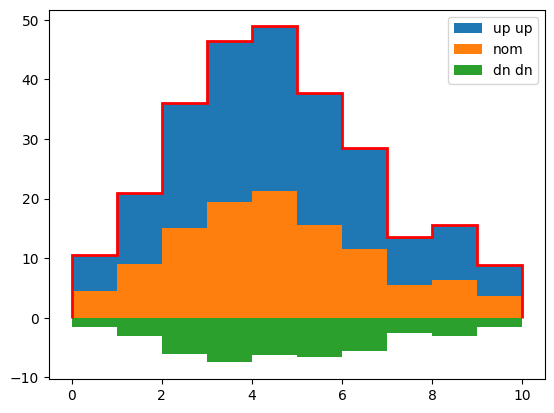

In [11]:
plt.stairs(hist2 + hist1 + hist1 + hist1 + hist2, bins, fill = True, label = 'up up')
# plt.stairs(hist2+hist2, bins, fill = True, label = '-- up')
plt.stairs(hist2 + hist1, bins, fill = True, label = 'nom')
# plt.stairs(hist2, bins, fill=True, label = '-- --')
plt.stairs(hist2 - hist1 + hist1 - hist1 - hist2, bins, fill=True, label = 'dn dn')
# plt.stairs(hist2-hist2, bins, fill=True, label = '-- dn')
# plt.stairs(hist2-hist1-hist2, bins, fill=True, label = 'dn dn')

initial_parameters = new_model.config.suggested_init()
initial_parameters[0] = 1.

plt.stairs(new_model.expected_data(initial_parameters, include_auxdata=False), bins, linewidth=2, color='r')

plt.legend()

# shapesys

In [12]:
samples = [
    {
        "name": "sample1",
        "data": list(hist2),
        "modifiers": [
            {"name": "mu", "type": "normfactor", "data" : None},
            {
                "name": "u1",
                "type": "shapesys",
                "data": list(hist1)
            },
            {
                "name": "u2",
                "type": "shapesys",
                "data": list(hist2)
            }
        ],
        
    },
]

spec = {
"channels" : [{"name" : "singlechannel", "samples" : samples}], 
"correlations": [
    {
        "name": "corr",
        "vars": ["u1", "u2"],
        "corr": [[1., 1.], [1., 1.]],
    }
]}

new_spec = decorrelate.decorrelate(spec)
new_model = pyhf.Model(new_spec)
new_spec

correlation found


{'channels': [{'name': 'singlechannel',
   'samples': [{'name': 'sample1',
     'data': [3.0, 6.0, 9.0, 12.0, 15.0, 9.0, 6.0, 3.0, 3.3, 2.15],
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None},
      {'type': 'shapesys',
       'data': array([ 4.5 ,  9.  , 15.  , 19.5 , 21.3 , 15.6 , 11.5 ,  5.5 ,  6.3 ,
               3.65]),
       'name': 'corr[0]'}]}]}]}

In [13]:
list((hist2 / (hist1+hist2)) ** 2)

[0.4444444444444444,
 0.4444444444444444,
 0.36,
 0.37869822485207105,
 0.4959333465582225,
 0.3328402366863906,
 0.2722117202268431,
 0.29752066115702475,
 0.2743764172335601,
 0.34696941264777637]

In [14]:
new_model.config.auxdata[:10]

[0.4444444444444444,
 0.4444444444444444,
 0.36,
 0.378698224852071,
 0.4959333465582225,
 0.33284023668639057,
 0.2722117202268431,
 0.2975206611570248,
 0.2743764172335601,
 0.3469694126477763]

# normsys

In [15]:
samples = [
    {
        "name": "sample1",
        "data": list(hist2),
        "modifiers": [
            {"name": "mu", "type": "normfactor", "data" : None},
            {
                "name": "u1",
                "type": "normsys",
                "data": {"hi": 2., "lo": 0.}
            },
            {
                "name": "u2",
                "type": "normsys",
                "data": {"hi": 3., "lo": 0.5}
            }
        ],
        
    },
]

spec = {
"channels" : [{"name" : "singlechannel", "samples" : samples}], 
"correlations": [
    {
        "name": "corr",
        "vars": ["u1", "u2"],
        "corr": [[1., 1.], [1., 1.]],
    }
]}

new_spec = decorrelate.decorrelate(spec)
new_model = pyhf.Model(new_spec)
new_spec

correlation found


{'channels': [{'name': 'singlechannel',
   'samples': [{'name': 'sample1',
     'data': [3.0, 6.0, 9.0, 12.0, 15.0, 9.0, 6.0, 3.0, 3.3, 2.15],
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None},
      {'type': 'normsys',
       'data': {'lo': 0.5, 'hi': 5.0},
       'name': 'corr[0]'}]}]}]}

In [16]:
initial_parameters = new_model.config.suggested_init()
initial_parameters[1] = -1

new_model.expected_data(initial_parameters, include_auxdata=False)

array([1.5  , 3.   , 4.5  , 6.   , 7.5  , 4.5  , 3.   , 1.5  , 1.65 ,
       1.075])

In [17]:
samples = [
    {
        "name": "sample1",
        "data": list(hist1),
        "modifiers": [
            {"name": "mu", "type": "normfactor", "data" : None},
            {
                "name": "u1",
                "type": "normsys",
                "data": {"hi": 2., "lo": 0.}
            },
            {
                "name": "u12",
                "type": "normsys",
                "data": {"hi": 3., "lo": 0.5}
            }
        ],
        
    },    
    {
        "name": "sample2",
        "data": list(hist2),
        "modifiers": [
            {
                "name": "u1",
                "type": "normsys",
                "data": {"hi": 4., "lo": 1.}
            },
        ],
        
    },
]

spec = {
    "channels" : [{"name" : "singlechannel", "samples" : samples}], 
    "correlations": [
        {
            "name": "corr",
            "vars": ["u1", "u12"],
            "corr": [[1., 1.], [1., 1.]],
        }
    ]}


new_spec = decorrelate.decorrelate(spec)
new_model = pyhf.Model(new_spec)
new_spec

correlation found


{'channels': [{'name': 'singlechannel',
   'samples': [{'name': 'sample1',
     'data': [1.5, 3.0, 6.0, 7.5, 6.3, 6.6, 5.5, 2.5, 3.0, 1.5],
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None},
      {'type': 'normsys', 'data': {'lo': 0.5, 'hi': 5.0}, 'name': 'corr[0]'}]},
    {'name': 'sample2',
     'data': [3.0, 6.0, 9.0, 12.0, 15.0, 9.0, 6.0, 3.0, 3.3, 2.15],
     'modifiers': [{'type': 'normsys',
       'data': {'lo': 1.0, 'hi': 4.0},
       'name': 'corr[0]'}]}]}]}

In [18]:
initial_parameters = new_model.config.suggested_init()
initial_parameters[1] = -1

new_model.expected_data(initial_parameters, include_auxdata=False)

array([ 3.75,  7.5 , 12.  , 15.75, 18.15, 12.3 ,  8.75,  4.25,  4.8 ,
        2.9 ])

In [19]:
0.5*hist1 + hist2

array([ 3.75,  7.5 , 12.  , 15.75, 18.15, 12.3 ,  8.75,  4.25,  4.8 ,
        2.9 ])

# staterror

In [20]:
samples = [
    {
        "name": "sample1",
        "data": list(hist2),
        "modifiers": [
            {"name": "mu", "type": "normfactor", "data" : None},
            {
                "name": "u1",
                "type": "staterror",
                "data": list(hist1)
            },
            {
                "name": "u2",
                "type": "staterror",
                "data": list(hist2)
            }
    ],
        
    },
]

spec = {
"channels" : [{"name" : "singlechannel", "samples" : samples}], 
"correlations": [
    {
        "name": "corr",
        "vars": ["u1", "u2"],
        "corr": [[1., 1.], [1., 1.]],
    }
]}

new_spec = decorrelate.decorrelate(spec)
new_model = pyhf.Model(new_spec)
new_spec

correlation found


{'channels': [{'name': 'singlechannel',
   'samples': [{'name': 'sample1',
     'data': [3.0, 6.0, 9.0, 12.0, 15.0, 9.0, 6.0, 3.0, 3.3, 2.15],
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None},
      {'type': 'staterror',
       'data': array([ 3.35410197,  6.70820393, 10.81665383, 14.1509717 , 16.26929624,
              11.16064514,  8.1394103 ,  3.90512484,  4.45982062,  2.62154535]),
       'name': 'corr[0]'}]}]}]}

In [21]:
new_model.config.param_set("corr[0]").width()

[1.118033988749895,
 1.118033988749895,
 1.2018504251546631,
 1.1792476415070754,
 1.0846197490364997,
 1.240071682515885,
 1.3565683830083088,
 1.3017082793177757,
 1.3514607952107733,
 1.2193234166435656]

In [22]:
list(np.sqrt(hist1**2 + hist2**2))/(hist2)

array([1.11803399, 1.11803399, 1.20185043, 1.17924764, 1.08461975,
       1.24007168, 1.35656838, 1.30170828, 1.3514608 , 1.21932342])

In [23]:
samples = [
    {
        "name": "sample1",
        "data": list(hist1),
        "modifiers": [
            {"name": "mu", "type": "normfactor", "data" : None},
            {
                "name": "u1",                        # same name
                "type": "staterror",
                "data" : list(hist1)                       # absolute yield uncertainties in each bin (Poisson error)
            }
        ],
    },
    {
        "name": "sample2",
        "data": list(hist2),
        "modifiers": [
            # {"name": "mu2", "type": "normfactor", "data" : None},
            {
                "name": "u2",                        # same name
                "type": "staterror",
                "data" : list(hist2)                       # absolute yield uncertainties in each bin (Poisson error)
            }
        ],
    },
]

spec = {
"channels" : [{"name" : "singlechannel", "samples" : samples}], 
"correlations": [
    {
        "name": "corr",
        "vars": ["u1", "u2"],
        "corr": [[1., 1.], [1., 1.]],
    }
]}

new_spec = decorrelate.decorrelate(spec)
new_model = pyhf.Model(new_spec)
new_spec

correlation found


{'channels': [{'name': 'singlechannel',
   'samples': [{'name': 'sample1',
     'data': [1.5, 3.0, 6.0, 7.5, 6.3, 6.6, 5.5, 2.5, 3.0, 1.5],
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None},
      {'type': 'staterror',
       'data': array([1.5, 3. , 6. , 7.5, 6.3, 6.6, 5.5, 2.5, 3. , 1.5]),
       'name': 'corr[0]'}]},
    {'name': 'sample2',
     'data': [3.0, 6.0, 9.0, 12.0, 15.0, 9.0, 6.0, 3.0, 3.3, 2.15],
     'modifiers': [{'type': 'staterror',
       'data': array([ 3.  ,  6.  ,  9.  , 12.  , 15.  ,  9.  ,  6.  ,  3.  ,  3.3 ,
               2.15]),
       'name': 'corr[0]'}]}]}]}

In [24]:
new_model.config.param_set("corr[0]").width()

[0.7453559924999299,
 0.7453559924999299,
 0.7211102550927979,
 0.7256908563120464,
 0.7638167246735915,
 0.7154259706822413,
 0.7077748085260742,
 0.7100226978096957,
 0.7079080355865955,
 0.718231601584566]

In [25]:
list(np.sqrt(hist1**2 + hist2**2)/(hist1 + hist2))

[0.7453559924999299,
 0.7453559924999299,
 0.7211102550927979,
 0.7256908563120464,
 0.7638167246735914,
 0.7154259706822413,
 0.7077748085260742,
 0.7100226978096958,
 0.7079080355865955,
 0.718231601584566]

# lumi, normfactor, shapefactor

In [26]:
samples = [
    {
        "name": "sample1",
        "data": list(hist2),
        "modifiers": [
            {"name": "mu", "type": "normfactor", "data" : None},
            {
                "name": "u1",
                "type": "normfactor",
                "data": None
            },
            {
                "name": "u2",
                "type": "normfactor",
                "data": None
            }
    ],
        
    },
]

# pyhf.Model(spec)

spec = {
"channels" : [{"name" : "singlechannel", "samples" : samples}], 
"correlations": [
    {
        "name": "corr",
        "vars": ["u1", "u2"],
        "corr": [[1., 1.], [1., 1.]],
    }
]}

new_spec = decorrelate.decorrelate(spec)
new_model = pyhf.Model(new_spec)
new_spec

correlation found


/filer/z-sv-pool12c/l/Lorenz.Gaertner/pyhf-corr/src/pyhfcorr/decorrelate.py:83: UserWarning: Modifiers without data can only be full (de)correlated and should be treated with pyhf directly.
  warnings.warn("Modifiers without data can only be full (de)correlated and should be treated with pyhf directly.")


{'channels': [{'name': 'singlechannel',
   'samples': [{'name': 'sample1',
     'data': [3.0, 6.0, 9.0, 12.0, 15.0, 9.0, 6.0, 3.0, 3.3, 2.15],
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None},
      {'name': 'u1', 'type': 'normfactor', 'data': None},
      {'name': 'u2', 'type': 'normfactor', 'data': None}]}]}]}

In [27]:
samples = [
    {
        "name": "sample1",
        "data": list(hist1),
        "modifiers": [
            {"name": "mu", "type": "normfactor", "data" : None},
            {
                "name": "u1",                        # same name
                "type": "normfactor",
                "data" : None                       # absolute yield uncertainties in each bin (Poisson error)
            }
        ],
    },
    {
        "name": "sample2",
        "data": list(hist2),
        "modifiers": [
            # {"name": "mu2", "type": "normfactor", "data" : None},
            {
                "name": "u2",                        # same name
                "type": "normfactor",
                "data" : None                       # absolute yield uncertainties in each bin (Poisson error)
            }
        ],
    },
]

spec = {
"channels" : [{"name" : "singlechannel", "samples" : samples}], 
"correlations": [
    {
        "name": "corr",
        "vars": ["u1", "u2"],
        "corr": [[1., 1.], [1., 1.]],
    }
]}

new_spec = decorrelate.decorrelate(spec)
new_model = pyhf.Model(new_spec)
new_spec

correlation found


{'channels': [{'name': 'singlechannel',
   'samples': [{'name': 'sample1',
     'data': [1.5, 3.0, 6.0, 7.5, 6.3, 6.6, 5.5, 2.5, 3.0, 1.5],
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None},
      {'name': 'u1', 'type': 'normfactor', 'data': None}]},
    {'name': 'sample2',
     'data': [3.0, 6.0, 9.0, 12.0, 15.0, 9.0, 6.0, 3.0, 3.3, 2.15],
     'modifiers': [{'name': 'u2', 'type': 'normfactor', 'data': None}]}]}]}